# Librerias
Aquí se ven todas las librerias que hemos tenido que importar para poder llevar a cabo nuestro análisi de los datos del parque de Yellowstone

In [69]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score

# Apartado C: Analizando datos
En este apartado lo que hemos hecho a sido cargar nuestra base de datos para poder entender con que tipo de datos estamos trabajando.

Como se observa aquí abajo hemos creado una primera función donde leeremos la base de datos en formato *csv* y lo cargaremos en un dataframe de la libreria *pandas*, y una vez cargado transformamos la columa *Year/Month/Day* que nos indicaba que día del mes se habían tomado los datos del paque. Esta transformación consiste en separar la fecha que teniamos en un *string* en dos columnas que hemos llamado *Year* y *Month*, con esto podremos ver que años o que meses viene más la gente, el día del mes no es necesario, ya que siempre se toman las muestras el día uno del mes, así que no nos aporta información.

In [70]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    
    dataset.loc[:,'Year/Month/Day'] = pd.to_datetime(dataset.loc[:,'Year/Month/Day'], infer_datetime_format=True)
    dataset.insert(20, 'Year', list(map(lambda x: x.year,dataset.loc[:,'Year/Month/Day'])), True)
    dataset.insert(21, 'Month', list(map(lambda x: x.month,dataset.loc[:,'Year/Month/Day'])), True)
    dataset = dataset.drop('Year/Month/Day', axis=1)
        
    return dataset

La siguiente función que encontramos abajo tiene la finalidad de tratar los valores que son *NaN*, como parámetro se le pasa el *dataset* y la política que le queramos aplicar. Tenemos 4 formas de tratar estos casos:
- DropNan: Es este caso si encontramos un valor que sea *NaN* eliminaremos la fila.
- 0: Este método consiste en poner a 0 todos los valores que sean *NaN*.
- Media: Igual que el método anterior pero substituyendo los valores por la media.
- Mediana: Aquísubstituimos por la mediana.
- Moda: En esta política substituimos por la moda

In [71]:
def MissingValues(DataSet, MissingValues):
    
    
    TamañoX, TamañoY = DataSet.shape
    NanNum = DataSet.isnull().sum().sum()
        
    #lista de con los nombres de los atributos pata hacer el .loc
    Atributos = []
    for col in DataSet.columns:
        Atributos.append(col)
    
   
    if(MissingValues == "DropNan"):
        
        es_NaN = DataSet.isnull()
        filas_con_NaN = es_NaN.any(axis=1)
        num_Filas_NaN, y = DataSet[filas_con_NaN].shape
        DataSet = DataSet[np.invert(filas_con_NaN)]
        print(num_Filas_NaN, " filas de datos han sido eliminados")
    
    if(MissingValues == "0"):
        DataSet[np.isnan(DataSet)] = 0
        print(NanNum," valores nulos han sido cambiados por 0")
    
    if(MissingValues == "Media"):
        for atributo in Atributos:
            DataSet.loc[:,atributo].fillna(DataSet.loc[:,atributo].mean())
        print(NanNum," valores han sido cambiados por su Media")
    
    if(MissingValues == "Mediana"):
        for atributo in Atributos:
            DataSet.loc[:,atributo].fillna(DataSet.loc[:,atributo].median())
        print(NanNum," valores han sido cambiados por su Mediana")
        
    if(MissingValues == "Mode"):
        for atributo in Atributos:
            DataSet.loc[:,atributo].fillna(DataSet.loc[:,atributo].median())
        print(NanNum," valores han sido cambiados por su Moda")
    return DataSet
    
    

Esta función nos sirve para eliminar aquellas filas que contengan *outliers*.

In [72]:
def RemoveOutliers(df):
    z_scores = scipy.stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

Ahora en este trozo de código es donde hacemos uso de las funciones anteriores, donde primero cargamos nuestro dataset y luego creamos 5 diferentes en función de la política que vayamos a usar para tratar los *NaN*, cada uno de estos dataset los limpiaremos utilizando la función de eliminar *outliers* que hemos comentado antes.

In [73]:
path = 'ysnp.csv'
#Missing values are DropNan, Media, Mediana, 0, Moda

# Cargamos dataset
dataset = load_dataset(path)

dataset_drop = MissingValues(dataset, 'DropNan')
dataset_media = MissingValues(dataset, 'Media')
dataset_mediana = MissingValues(dataset, 'Mediana')
dataset_moda = MissingValues(dataset, 'Mode')
dataset_zero = MissingValues(dataset, '0')
dataset_drop = RemoveOutliers(dataset_drop)
dataset_media = RemoveOutliers(dataset_media)
dataset_mediana = RemoveOutliers(dataset_mediana)
dataset_moda = RemoveOutliers(dataset_moda)
dataset_zero = RemoveOutliers(dataset_zero)
dataset_drop.head()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    print(dataset)


42  filas de datos han sido eliminados
85  valores han sido cambiados por su Media
85  valores han sido cambiados por su Mediana
85  valores han sido cambiados por su Moda
85  valores nulos han sido cambiados por 0


,Recreation Visits,LowestTemperature(F),HighestTemperature(F),WarmestMinimumTemperature(F),ColdestMaximumTemperature(F),AverageMinimumTemperature(F),AverageMaximumTemperature(F),MeanTemperature(F),TotalPrecipitation(In),TotalSnowfall(In),...,Max 24hrSnowfall(In),3month Percent Change Airfare Costs,3month Percent Change Food Away From Home Costs,3month Percent Change Gasoline Costs,3month Percent Change Jet Fuel Costs,Consumer Price Index,Consumer Sentiment Index,Unemployment Rate,Year,Month
0,30621,-17.0,37.0,23.0,10.0,8.9,29.3,19.1,1.09,16.1,...,6.5,-0.3,0.6,-7.3,-23.2,0.2,92.0,4.9,2016,1
2,26778,-19.0,41.0,26.0,5.0,3.8,27.1,15.5,1.28,14.1,...,2.5,-3.6,0.5,4.2,5.7,0.4,81.2,6.6,2014,1
3,24699,-22.0,43.0,30.0,6.0,1.2,23.5,12.3,0.61,11.5,...,3.8,3.8,0.4,-8.1,-0.5,0.3,73.8,8.0,2013,1
4,24766,-14.0,41.0,28.0,14.0,6.6,29.4,18.0,1.13,15.0,...,3.0,0.5,0.8,0.1,9.1,0.4,75.0,8.3,2012,1
5,24517,2.0,41.0,27.0,12.0,17.8,30.5,24.1,0.15,5.1,...,1.4,7.7,0.4,10.4,12.7,0.5,74.2,9.1,2011,1


Por cada política aplicada hemos mostrado las filas que ha eliminado o atributos que ha modificado, luego de eso podemos ver un ejemplo de como es el dataset limpio con la política de drop. El siguiente paso que tomaremos será ver las correlación de los atributos en cada uno de nuestros *dataframes*.

## Política Drop NaN
Eliminamos las filas que contienen un NaN en alguno de sus atributos

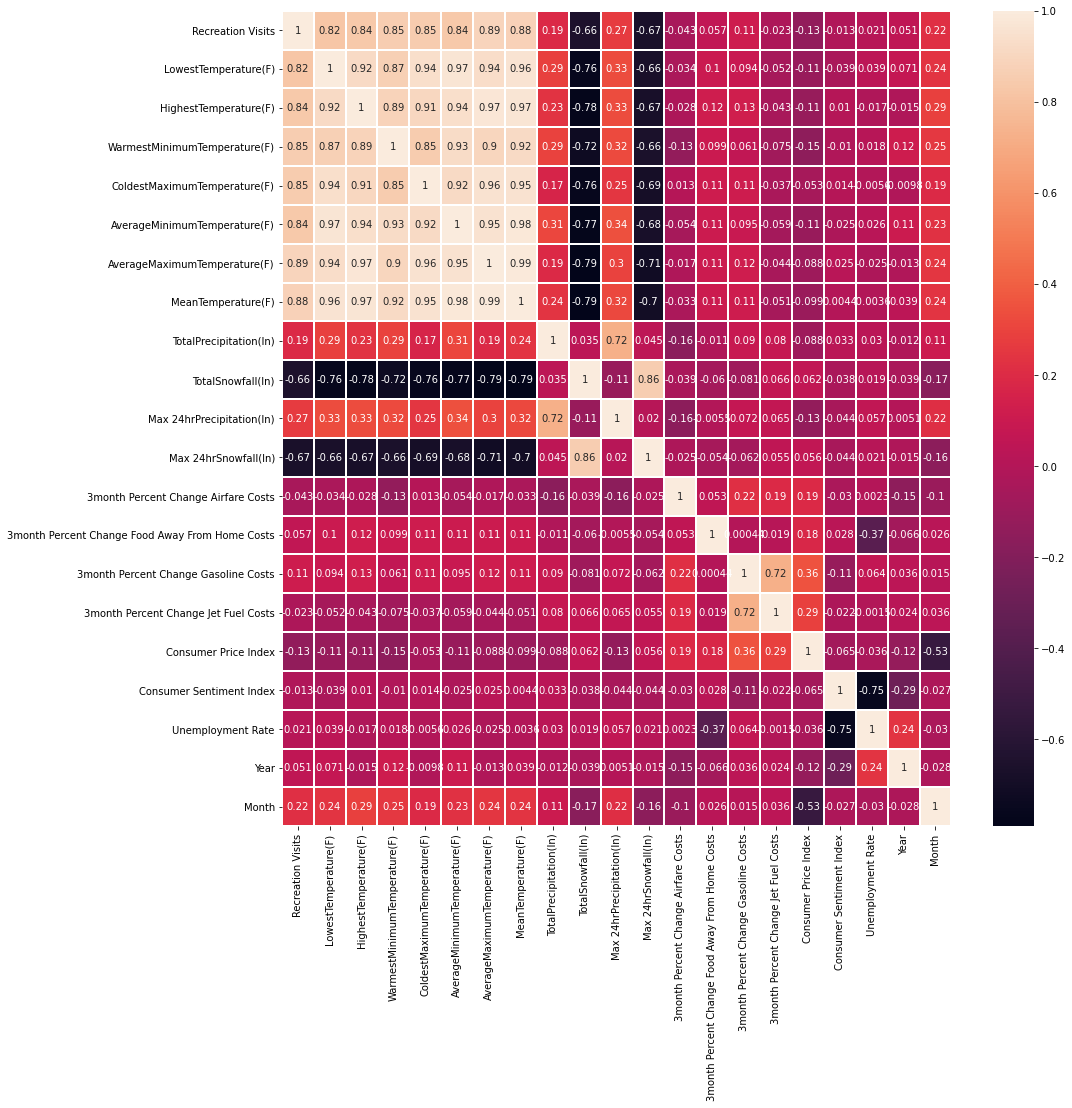

In [74]:
correlacio_drop = dataset_drop.corr()

plt.figure(figsize=(15,15))

ax = sns.heatmap(correlacio_drop, annot=True, linewidths=1)

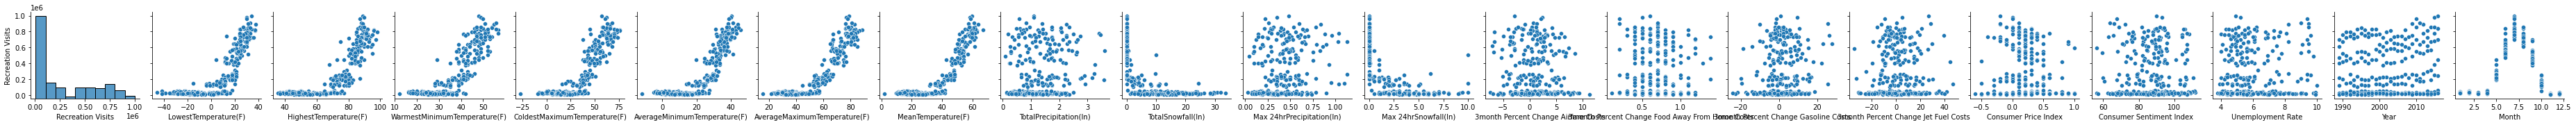

In [75]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset_drop, y_vars=['Recreation Visits'])

## Política Media
Substituimos los valores NaN por la media

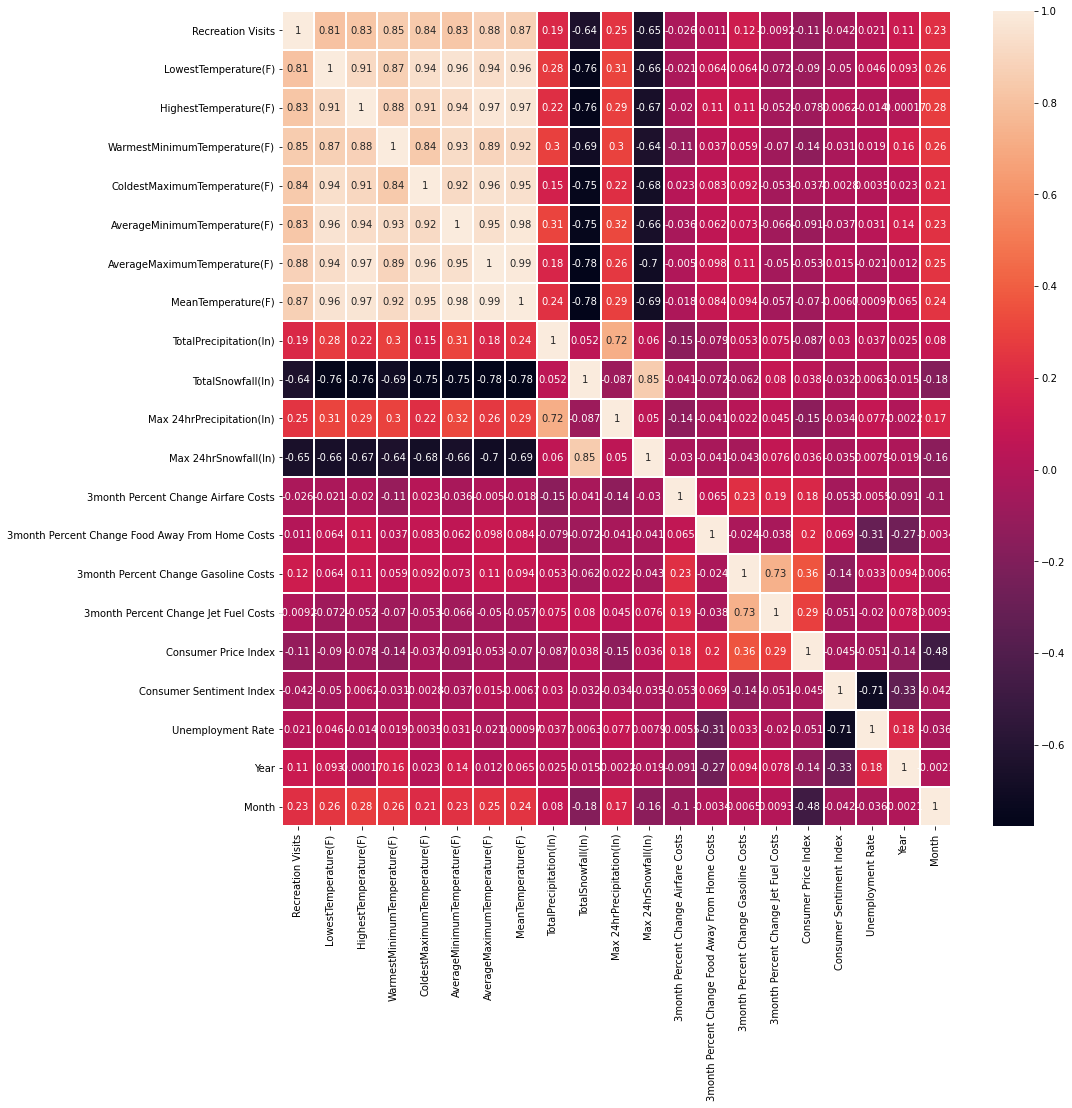

In [76]:
correlacio = dataset_media.corr()

plt.figure(figsize=(15,15))

ax = sns.heatmap(correlacio, annot=True, linewidths=1)

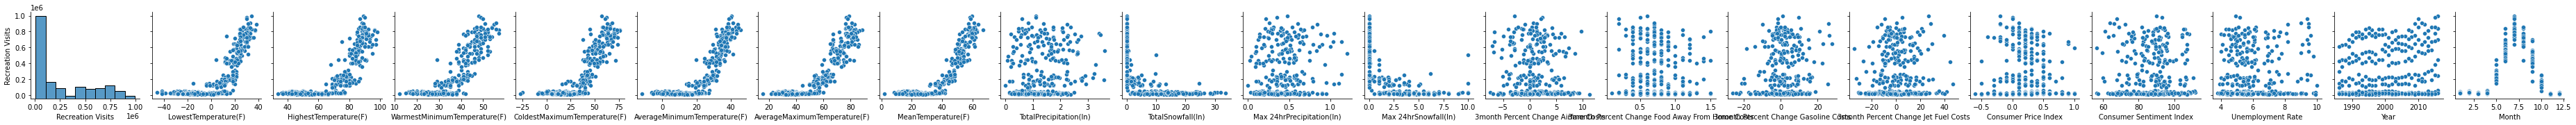

In [77]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset_media, y_vars=['Recreation Visits'])

## Política Mediana
Substituimos los valores NaN por la mediana

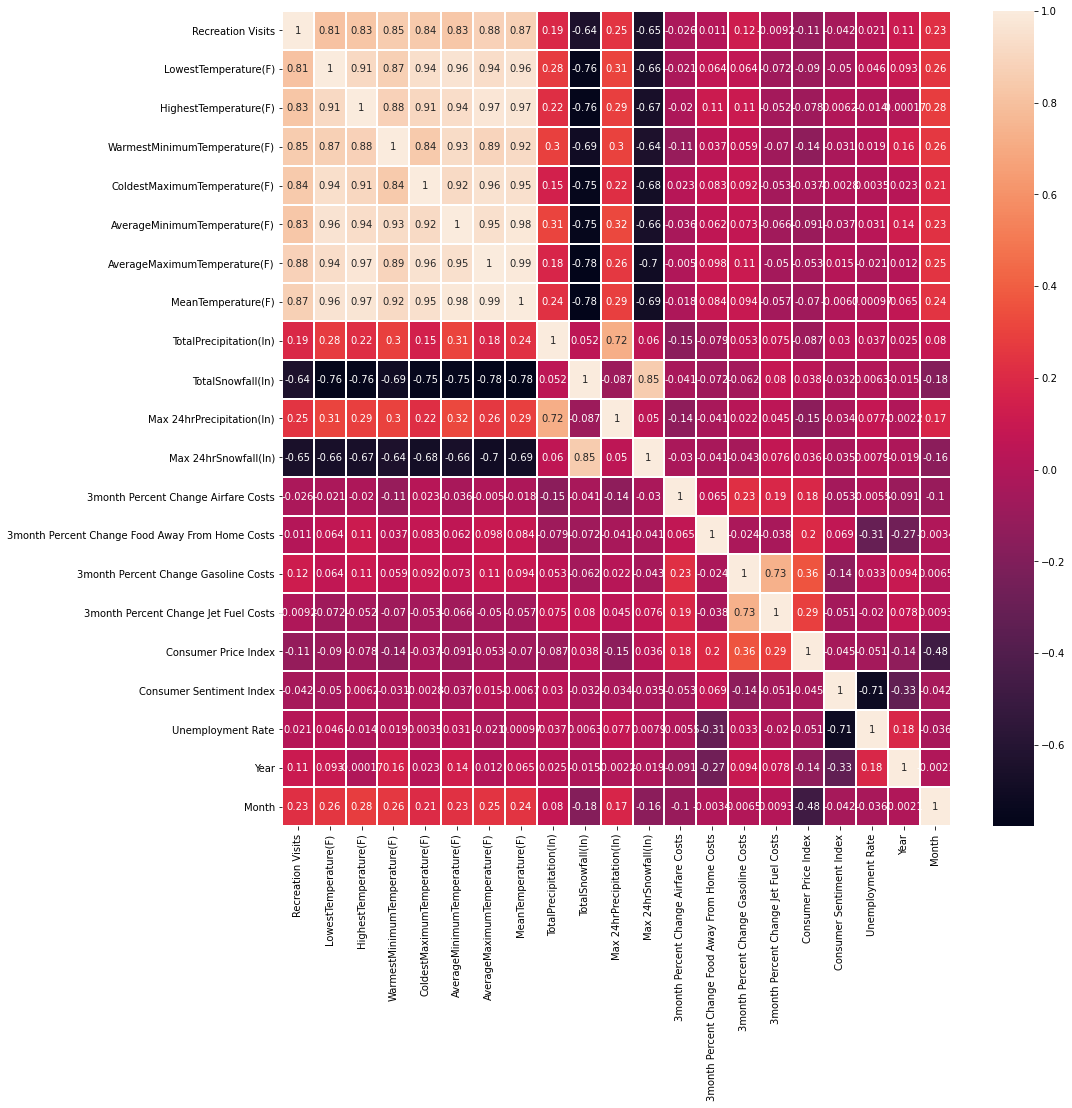

In [78]:
correlacio = dataset_mediana.corr()

plt.figure(figsize=(15,15))

ax = sns.heatmap(correlacio, annot=True, linewidths=1)

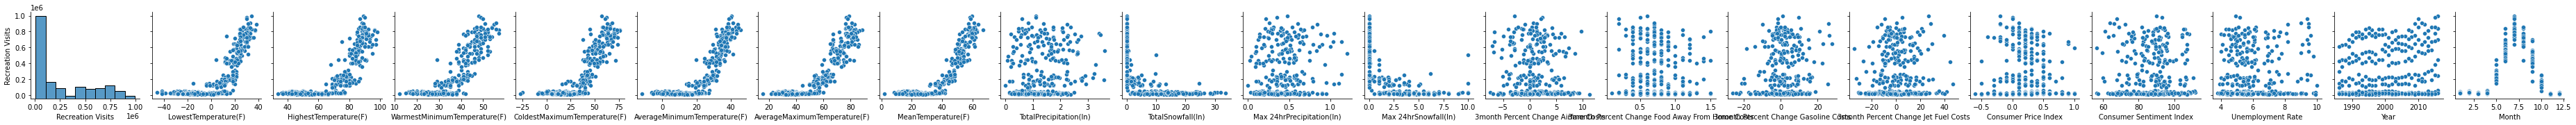

In [79]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset_mediana, y_vars=['Recreation Visits'])

## Política Moda
Substituimos los valores NaN por la moda

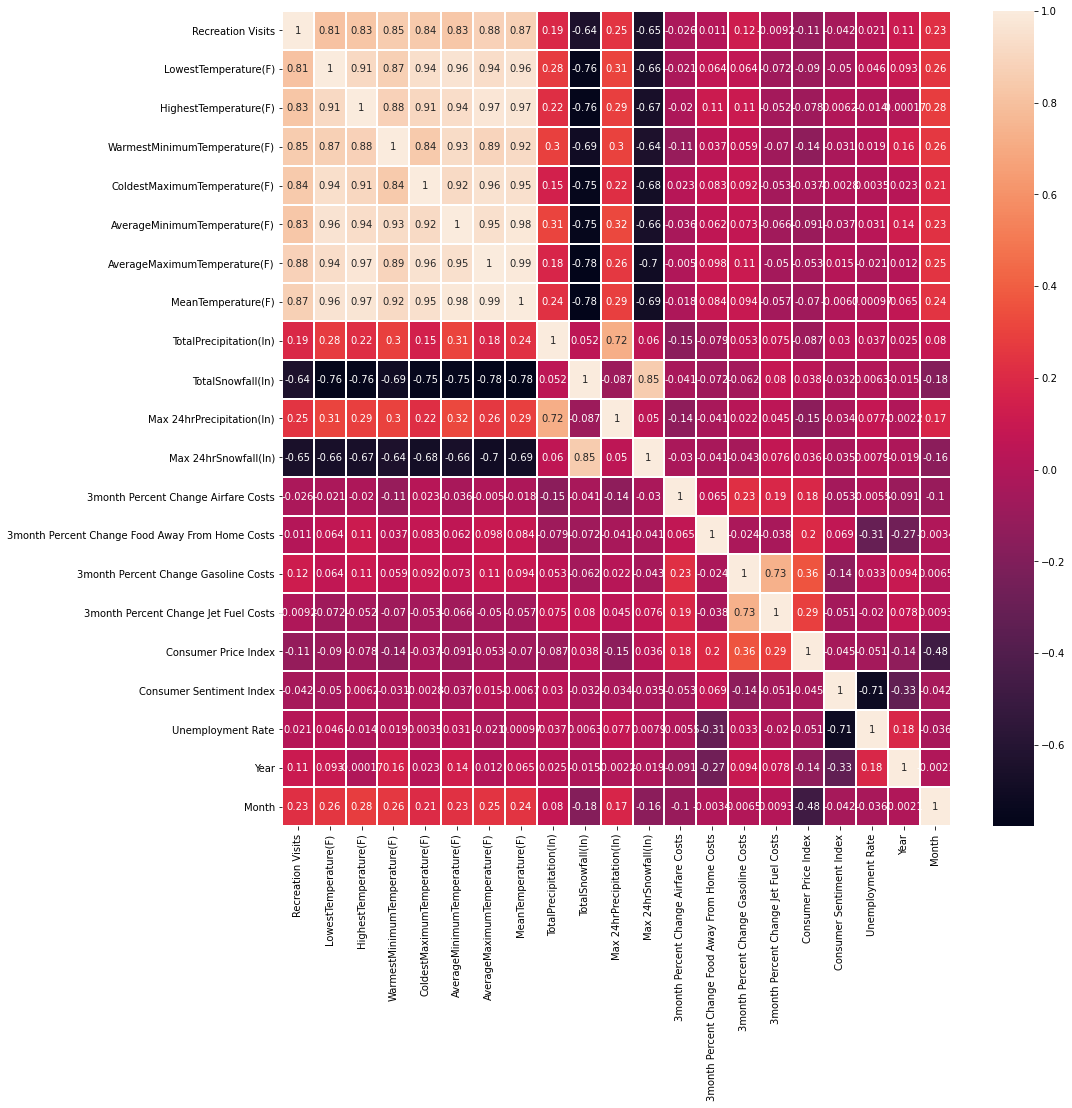

In [80]:
correlacio = dataset_moda.corr()

plt.figure(figsize=(15,15))

ax = sns.heatmap(correlacio, annot=True, linewidths=1)

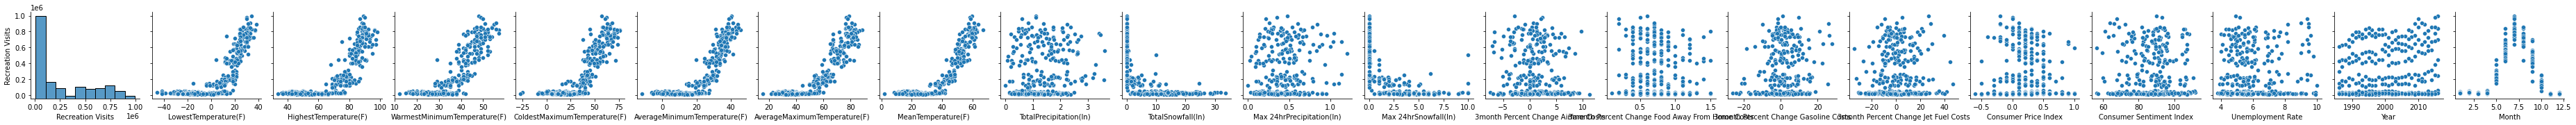

In [81]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset_moda, y_vars=['Recreation Visits'])

## Política Zero
Substituimos los valores NaN por zero

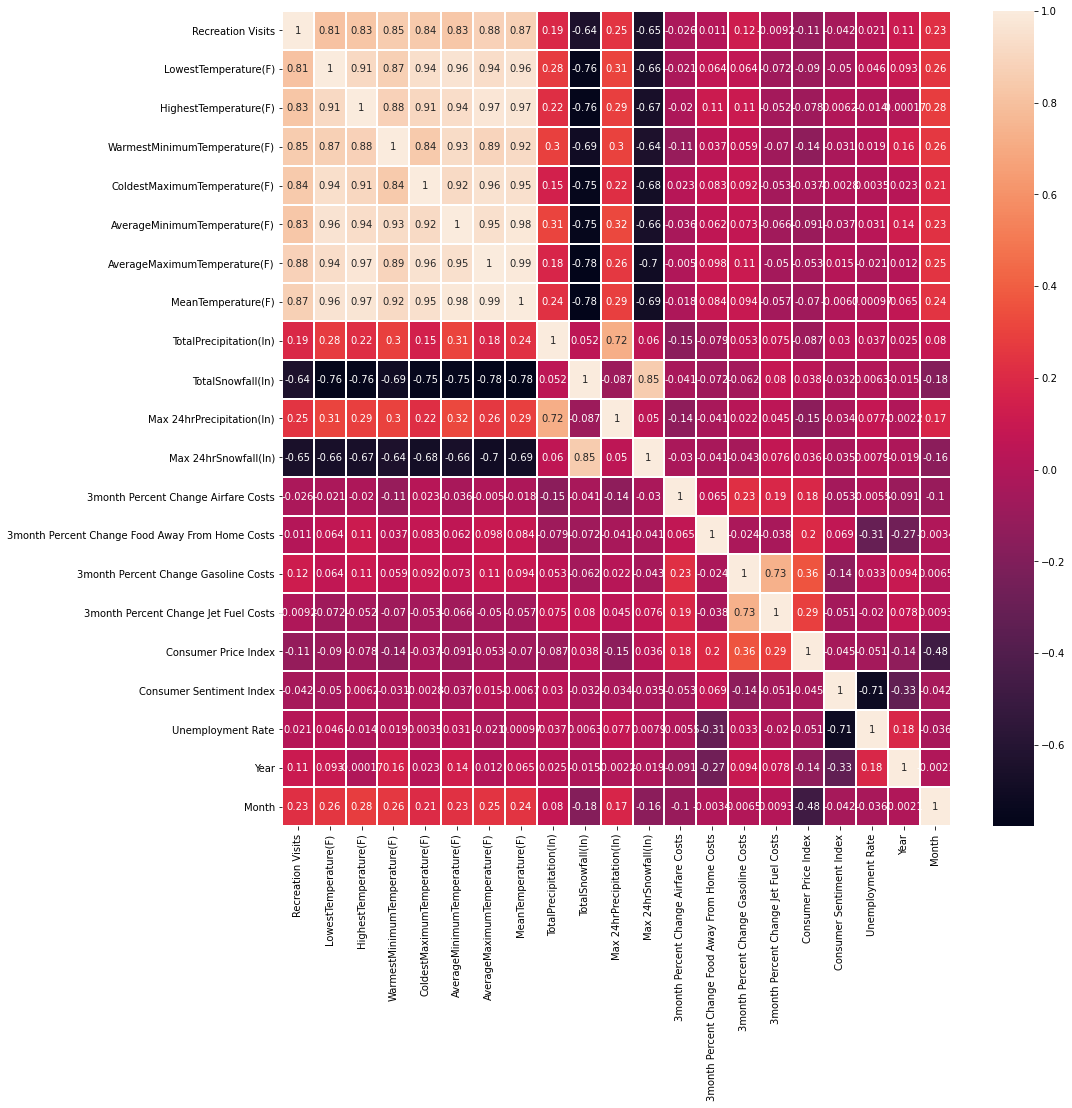

In [82]:
correlacio = dataset_zero.corr()

plt.figure(figsize=(15,15))

ax = sns.heatmap(correlacio, annot=True, linewidths=1)

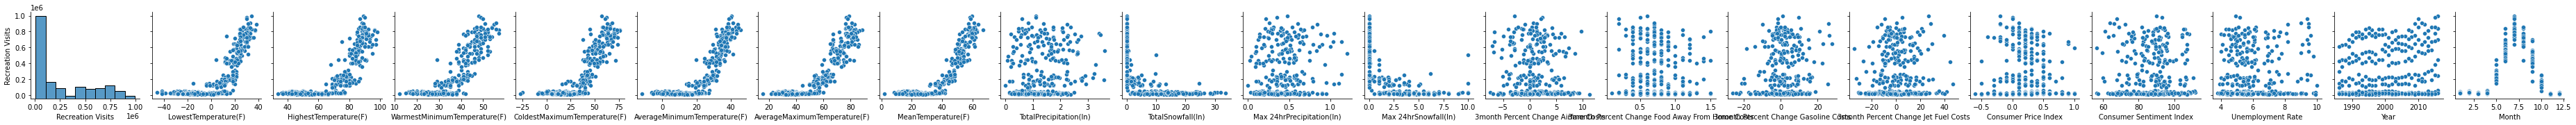

In [83]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset_zero, y_vars=['Recreation Visits'])

Como podemos observar en ninguna política hay un cambio significativo, si hubiese que destacar alguna sería la substitución por zero, ya que es en la que más se ha notado la correlación, pero como deciamos antes no le daremos gran importancia porque es bastante pequeña.

Lo siguiente que queremos visualizar son los histogramas de los atributos, así podremos cuales tienen una distribución gaussiana.

In [84]:
def histogramas(dataset, index):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    data = dataset.values
    columnName = list(dataset)
    x = data[:, index]
    plt.figure()
    title="Histograma de l'atribut "
    plt.title(title)
    plt.xlabel(columnName[index])
    plt.ylabel("Count")
    hist = plt.hist(x, bins=11, range=[np.min(x), np.max(x)], histtype="bar", rwidth=0.8)

/home/javier/anaconda3/envs/apc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 640x480 with 0 Axes>

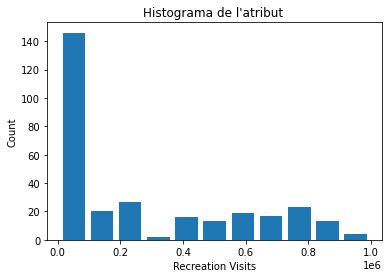

<Figure size 640x480 with 0 Axes>

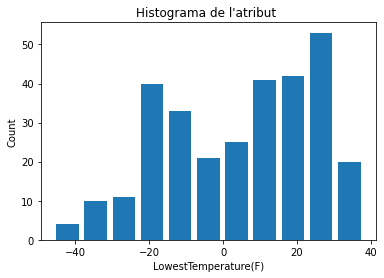

<Figure size 640x480 with 0 Axes>

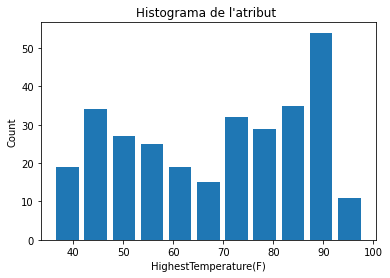

<Figure size 640x480 with 0 Axes>

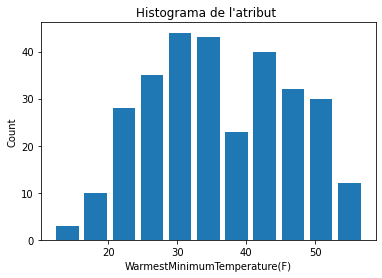

<Figure size 640x480 with 0 Axes>

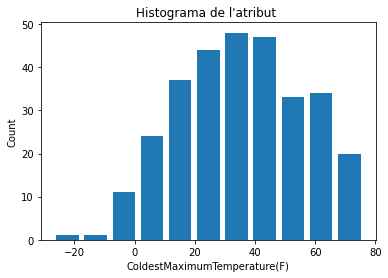

<Figure size 640x480 with 0 Axes>

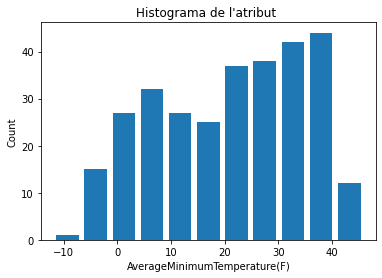

<Figure size 640x480 with 0 Axes>

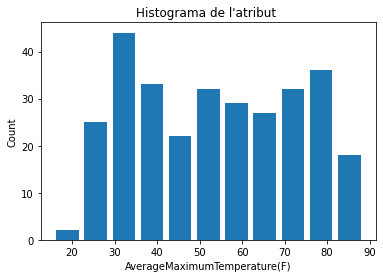

<Figure size 640x480 with 0 Axes>

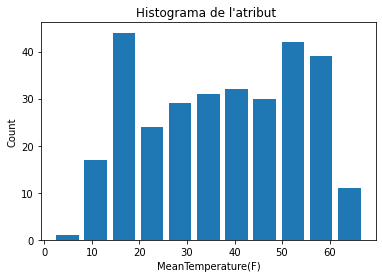

<Figure size 640x480 with 0 Axes>

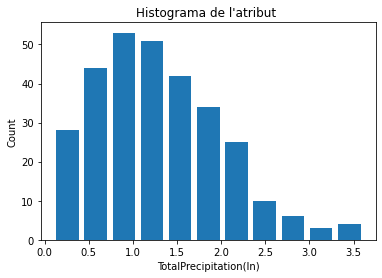

<Figure size 640x480 with 0 Axes>

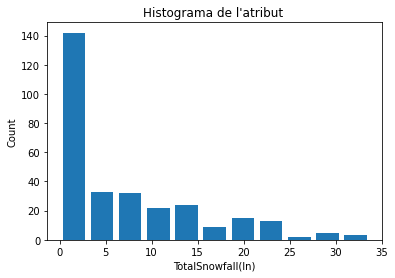

<Figure size 640x480 with 0 Axes>

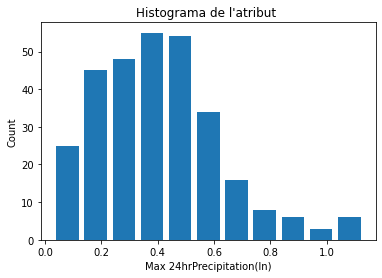

<Figure size 640x480 with 0 Axes>

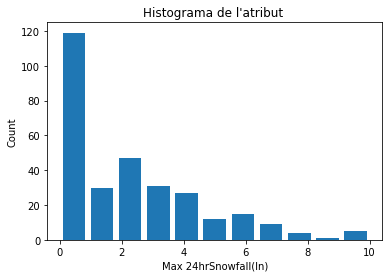

<Figure size 640x480 with 0 Axes>

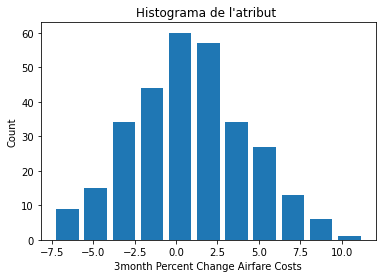

<Figure size 640x480 with 0 Axes>

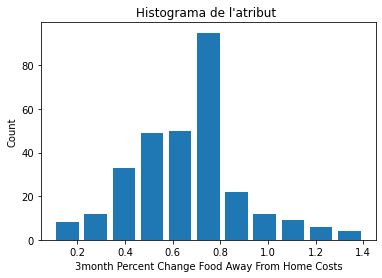

<Figure size 640x480 with 0 Axes>

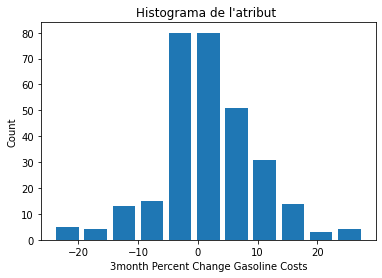

<Figure size 640x480 with 0 Axes>

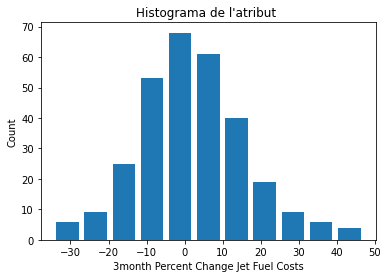

<Figure size 640x480 with 0 Axes>

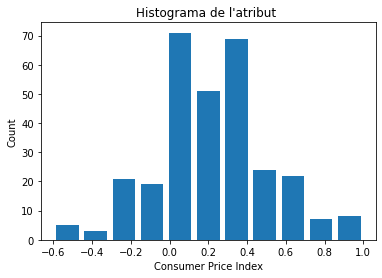

<Figure size 640x480 with 0 Axes>

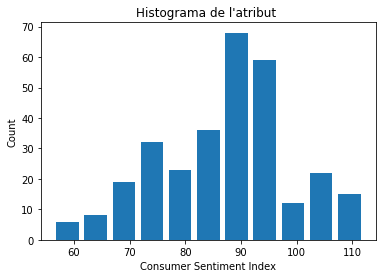

<Figure size 640x480 with 0 Axes>

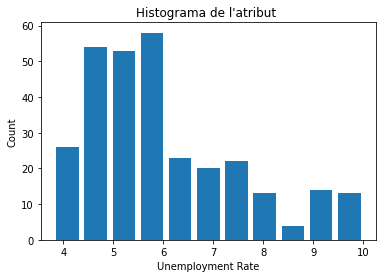

<Figure size 640x480 with 0 Axes>

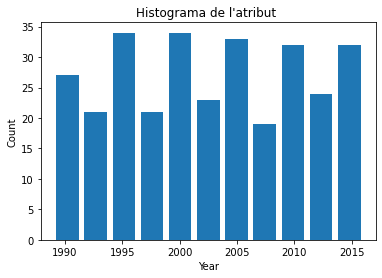

<Figure size 640x480 with 0 Axes>

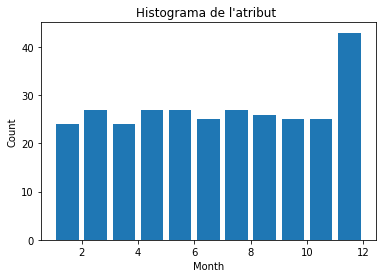

In [85]:
for i in range(dataset.shape[1]):
    histogramas(dataset_drop, i)

# Preguntas
1. Quin és el tipus de cada atribut?

La base de datos se compone de 20 atributo, los cuales todos són numéricos excepto *Year/Month/Day* que es un *string*. Ahora acontinuación describiremos cada atributo:
- *Recreation Visits*: Es la cantidad de visitas que recibe el parque.
- *LowestTemperature(F)*: Son las temperaturas mínimas medidas en Farenheit.
- *HighestTemperature(F)*: Son las temperaturas máximas medidas en Farenheit.
- *WarmestMinimumTemperature(F)*: Son las temperaturas mínimas más calidas.
- *ColdestMaximumTemperature(F)*: Son las temperaturas máximas más frías.
- *AverageMinimumTemperature(F)*: Es la media de las temperaturas más bajas.
- *AverageMaximumTemperature(F)*: Es la media de las temperaturas más altas.
- *MeanTemperature(F)*: Es las media de las temperaturas.
- *TotalPrecipitation(In)*: Precipitaciones totales en el mes.
- *TotalSnowfall(In)*: Cantidad de nieve total en el mes.
- *Max 24hrSnowfall(In)*: Precipitaciones máximas en 24 horas.
- *Max 24hrPrecipitation(In)*: Nevada máxima em 24 horas.
- *3month Percent Change Airfare Costs*: Es el porcentage de variación en el precio de las aerolineas.
- *3month Percent Change Food Away From Home Costs*: Es el porcentage de variación en el precio de comer fuera del hogar.
- *3month Percent Change Gasoline Costs*: Es el porcentage de variación en el precio de la gasolina.
- *3month Percent Change Jet Fuel Costs*: Es el porcentage de variación en el precio del combustible para aviones.
- *Consumer Price Index*: Medida que examina el promedio ponderado de los precios de una canasta de bienes y servicios de consumo, [+info](https://www.investopedia.com/terms/c/consumerpriceindex.asp).
- *Consumer Sentiment Index*: Son los resultados de la encuesta de sentimiento que se realiza en Estados Unidos que recolecta información sobre el estado económico personal y familiar del individuo,  [+info](http://www.cis.es/cis/opencms/ES/13_Indicadores/Indicadores/ICC/index.jsp).
- *Unemployment Rate*: Esta es la tasa de desempleo.
- *Year/Month/Day*: Este atributo indica la fecha, pero lo hemos divido en tres atributos númericos que son:
    - *Year*: Indica el año.
    - *Month*: Indica el mes.
    - *Day*: Indica el día.

2. Quins atributs tenen una distribució Guassiana?

Podemos apreciar que no hay muchos atributos que dispongan de este tipo de distribución, paradógicamente, la mayoría de los que si que cumplen esta condición no tiene una gran correlación con el atributo objetivo (*RecreationVisits*) y en el siguiente apartado es posible que se descarten. Los atributos que disponen de esta distribución son los siguientes:
- *WarmestMinimumTemperature(F)*: Esta es una de las que tiene correlación alta.
- *ColdestMaximumTemperature(F)*: Esta lo otra que también tiene una alta correlación
- *TotalPrecipitation(In)*:. Baja correlación.
- *Max 24hrPrecipitation(In)*: Baja correlación.
- *3month Percent Change Airfare Costs*: Baja correlación.
- *3month Percent Change Food Away From Home Costs*: Baja correlación.
- *3month Percent Change Gasoline Costs*: Baja correlación.
- *3month Percent Change Jet Fuel Costs*: Baja correlación.
- *Consumer Price Index*: Baja correlación.
- *Consumer Sentiment Index*: Baja correlación.

La distribución gaussiana no nos indica que los datos tengan relación con el objetivo, pero lo que si nos muestran es que lo datos son de calidad y que si tuviesen una buena correlación sería de mucha importancia para el estudio, ya que cuando los datos se distribuyen de esta manera nos aseguramos de que, por ejemplo, en una columna todos los valores sean igual, ya que eso no nos serviría de nada.

3. Quin és l'atribut objectiu? Per què?

El atributo objetivo es *Recreation Visits*, esto viene dado en la base de datos que nos especifica que quiere encontrar que factores afectan a la cantidad de visitas. De todas maneras muchos de los atributos que encontramos no tiene una correlación que nos pueda aportar nada, en algunos casos incluso no tiene sentido y si encontrasemos una correlación sería más a causa de la casualidad que no de la causalidad.


# Apartado B Regresión (I)
En este apartado buscaremos un modelo que nos prediga con bastante acierto las visitas dadas una condiciones (atributos). A continuación describiremos las funciones que creamos y iremos explicando para que sirven cuando sea oportuno, al final sacaremos las conclusiones del resultado de nuestra regresión y resolveremos unas preguntas.

Esta función que vemos abajo sirve para estandarizar, para poder trabajar más cómodamente y de manera más eficaz con los datos necesitaremos aplicar este proceso, más adelante se hace una demostración de lo que explicamos aquí

In [86]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean
    x_t /= std
    return x_t

Para poder tener un buen modelo no podemos entrenarlo con todos los datos, así que con esta función lo que haremos será crear un set de entrenamiento y otro para el test, por defecto si no se especifica lo contrario, se entrenará con un 80% de los datos y el resto será para la validación

In [87]:
def CreateSets(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, x_val, y_train, y_val

En esta función es en la que se crea el objeto *LinearRegression* y se entreno dados los atributos de entrenamiento y el output de entrenamiento.

In [88]:
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Con este método conseguiremos el cálculo del error basandonos en la fórmula de la media de los errores cuadrados, la cual, como su nombre indica, se basa en encontrar la diferencia entre lo esperado y lo predecido, elevarlo al cuadrado y hacer la media.

In [89]:
def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

Aquí en este método encontramos donde se llama a las funciones anteriores para encontrar el modelo y devolver el error, también devolveremos el coeficiente r2. Como podemos ver lo primero que hacemos en dividir los datos entre entrenamiento  validación y posteriormente nos encontramos con una condición, esta condición se utiliza ya que uno de los objetivos de este apartado era encontrar los errores de cada atributo, y el segundo era encontrar el modelo con varios atributos. Cuando utilizamos más de un atributos a parte de encontrar el modelo nos interesa poder visualizarlo en una gráfica en dos dimensiones, lo que nos hace necesitar el PCA, que reduce todos los atributos en uno en este caso.

En nuestra práctica utilizamos también el objeto *PolynomialFeatures*, esto es porque hemos profundizado más en el tema y hemos encontrado una manera de que nuestro modelo posea más grados. De momento hacemos la práctica tal como sigue el guión pero luego mostraremos lo que hemos encontrado en un apartado extra.

In [90]:
def valorate_dataset(x, y, index=None, train_percent=0.8, plot=True, degree=1):
    ###Inicializar variables###
    #data = dataset.values
    #columnName = list(dataset)
    #x = data[:, 1:]
    #print(type(x))
    #y = data[:, 0]
    #y_t = standarize(y)
    (x_train, x_test, y_train, y_test) = CreateSets(x, y, train_percent)
 
    
    
    if(index != None):
        atribut_train = x_train[:,index].reshape(x_train.shape[0], 1)
        atribut_test = x_test[:,index].reshape(x_test.shape[0], 1)
        regr = regression(atribut_train, y_train)
        predicciones = regr.predict(atribut_test)
        return mean_squeared_error(y_test, predicciones), r2_score(y_test, predicciones)

    else:
        atribut_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
        atribut_test = x_test.reshape(x_test.shape[0], x_train.shape[1])
        pf = PolynomialFeatures(degree=degree)
        atribut_train=pf.fit_transform(atribut_train)
        atribut_test=pf.fit_transform(atribut_test)
        regr = regression(atribut_train, y_train)
        predicciones = regr.predict(atribut_test)
        model_error = mean_squeared_error(y_test, predicciones) #Calculamos el error del modelo sin PCA
        model_r2 = r2_score(y_test, predicciones)

        
        pca = PCA(n_components=1)
        principal_components_train = pca.fit_transform(x_train)
        principal_components_test = pca.fit_transform(x_test)
        principal_components_train_r=pf.fit_transform(principal_components_train)
        principal_components_test_r=pf.fit_transform(principal_components_test)
        regr_pca = regression(principal_components_train_r, y_train)
        predicciones_pca = regr_pca.predict(principal_components_test_r)
        pca_error = mean_squeared_error(y_test, predicciones_pca) #Calculamos el error del modelo con PCA
        pca_r2 = r2_score(y_test, predicciones_pca)
        if plot:
            plt.figure()
            ax = plt.scatter(principal_components_test, y_test)
            x_plot = []
            y_plot = []
            i = -6
            while (i<7):
                x_plot.append(i)
                i += 0.2
            x_plot_array = np.array(x_plot)
            x_plot_array = x_plot_array.reshape(x_plot_array.shape[0], 1)
            x_plot_array_r = pf.fit_transform(x_plot_array)
            y_plot_array = regr_pca.predict(x_plot_array_r)
            plt.plot(x_plot_array, y_plot_array, color='red', linewidth=3)
            plt.show()
        return (regr, model_error, regr_pca, pca_error, model_r2, pca_r2)
    


Este sería el código principal que se usa para encontrar los errores y la correlación de cada atributo, lo necesario para entender este códifo esque primeramente preparamos los datos para poder ejecutar las funciones y luego imprimimos los erroes de cada atributo en cada política y de forma estandarzada y no estandarizada.

In [91]:
'''
Estandarizamos el dataset
'''
standar_drop = []
standar_media = []
standar_mediana = []
standar_moda = []
standar_zero = []
for i in range(dataset.shape[1]):
    standar_drop.append(standarize(dataset_drop.values[:,i]))
    standar_media.append(standarize(dataset_media.values[:,i]))
    standar_mediana.append(standarize(dataset_mediana.values[:,i]))
    standar_moda.append(standarize(dataset_moda.values[:,i]))
    standar_zero.append(standarize(dataset_zero.values[:,i]))
np_standar_drop = np.transpose(np.array(standar_drop))
np_standar_media = np.transpose(np.array(standar_media))
np_standar_mediana = np.transpose(np.array(standar_mediana))
np_standar_moda = np.transpose(np.array(standar_moda))
np_standar_zero = np.transpose(np.array(standar_zero))
'''
Calculamos el error con los datos estandarizado y los no estnadarizados   df.to_numpy() 
'''
mse_drop = []
mse_moda = []
mse_media = []
mse_zero = []
mse_mediana = []
mse_drop_standard = []
mse_moda_standard = []
mse_media_standard = []
mse_zero_standard = []
mse_mediana_standard = []

x_drop = dataset_drop.values[:, 1:]
y_drop = dataset_drop.values[:, 0]
x_media = dataset_media.values[:, 1:]
y_media = dataset_media.values[:, 0]
x_mediana = dataset_mediana.values[:, 1:]
y_mediana = dataset_mediana.values[:, 0]
x_moda = dataset_moda.values[:, 1:]
y_moda = dataset_moda.values[:, 0]
x_zero = dataset_zero.values[:, 1:]
y_zero = dataset_zero.values[:, 0]
for i in range(dataset.shape[1]-1):
    mse_drop.append([list(dataset)[i+1], valorate_dataset(x_drop, y_drop, i)])
    mse_media.append([list(dataset)[i+1], valorate_dataset(x_media, y_media, i)])
    mse_mediana.append([list(dataset)[i+1], valorate_dataset(x_mediana, y_mediana, i)])
    mse_moda.append([list(dataset)[i+1], valorate_dataset(x_moda, y_moda, i)])
    mse_zero.append([list(dataset)[i+1], valorate_dataset(x_zero, y_zero, i)])
    mse_drop_standard.append([list(dataset)[i+1], valorate_dataset(np_standar_drop[:,1:], np_standar_drop[:,0], i)])
    mse_media_standard.append([list(dataset)[i+1], valorate_dataset(np_standar_media[:,1:], np_standar_media[:,0], i)])
    mse_mediana_standard.append([list(dataset)[i+1], valorate_dataset(np_standar_mediana[:,1:], np_standar_mediana[:,0], i)])
    mse_moda_standard.append([list(dataset)[i+1], valorate_dataset(np_standar_moda[:,1:], np_standar_moda[:,0], i)])
    mse_zero_standard.append([list(dataset)[i+1], valorate_dataset(np_standar_zero[:,1:], np_standar_zero[:,0], i)])

print('drop: ')
print(mse_drop)
print('----------------------------')
print('zero: ')
print(mse_zero)
print('----------------------------')
print('media: ')
print(mse_media)
print('----------------------------')
print('moda: ')
print(mse_moda)
print('----------------------------')
print('mediana: ')
print(mse_mediana)
print('----------------------------')
print('drop estandard: ')
print(mse_drop_standard)
print('----------------------------')
print('zero estandard: ')
print(mse_zero_standard)
print('----------------------------')
print('media estandard: ')
print(mse_media_standard)
print('----------------------------')
print('moda estandard: ')
print(mse_moda_standard)
print('----------------------------')
print('mediana estandard: ')
print(mse_mediana_standard)
print('----------------------------')

drop: 
[['LowestTemperature(F)', (31469970446.64726, 0.6636573294261879)], ['HighestTemperature(F)', (26510326726.892452, 0.7083758127875818)], ['WarmestMinimumTemperature(F)', (21608363433.917274, 0.7478324567541865)], ['ColdestMaximumTemperature(F)', (31267845361.3343, 0.593301057155055)], ['AverageMinimumTemperature(F)', (30849301053.99457, 0.6747640318758588)], ['AverageMaximumTemperature(F)', (20366616154.255623, 0.7397517906658323)], ['MeanTemperature(F)', (18675404040.133377, 0.793606492322571)], ['TotalPrecipitation(In)', (96082060732.11458, -0.020796963400571133)], ['TotalSnowfall(In)', (46962087466.69784, 0.3841660928538517)], ['Max 24hrPrecipitation(In)', (98552049900.30545, -0.04631616906412783)], ['Max 24hrSnowfall(In)', (64067988036.23872, 0.35095333827361275)], ['3month Percent Change Airfare Costs', (89572108842.55948, 0.004604615852850769)], ['3month Percent Change Food Away From Home Costs', (103287161697.32768, -0.009598384608214827)], ['3month Percent Change Gasolin

Lo primero que vemos es que las unidades de error con los datos estandarizados son mucho menores, lo que los hace más entendibles. Lo segundo que vemos es que hay valores que dan mucho error y otros muy poco, si observamos bien podemos apreciar que los que generan un error muy grande coinciden con los que tienen un valor de correlación menor, ahora es solo una observación, pero más adelante retormaremos esto para limpiar los datos y utilizar los más óptimos para la regressión. A partir de este momento dejaremos de utilizar los datos no estandarizados

## Regresion lineales
Ahora vamos a probar que error tiene los dataset con las diferentes políticas y con todos los atributos.

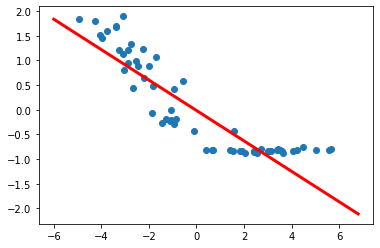

MSE model:  0.13035299098240377
R2 model:  0.8584416888276878
MSE pca:  0.19801005740496772
R2 pca:  0.7849687290630444


In [92]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_drop[:,1:], np_standar_drop[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

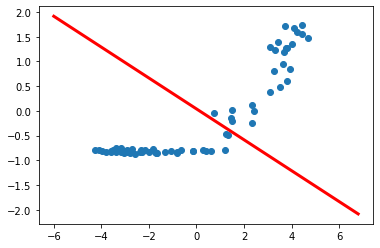

MSE model:  0.1584366013409093
R2 model:  0.8066267411708736
MSE pca:  3.122736583375843
R2 pca:  -2.8113273352348775


In [93]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_media[:,1:], np_standar_media[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

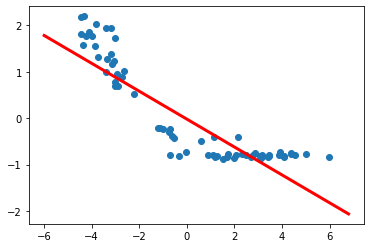

MSE model:  0.13200777891055637
R2 model:  0.8845675416382398
MSE pca:  0.23930613117056196
R2 pca:  0.7907419149838388


In [94]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_mediana[:,1:], np_standar_mediana[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

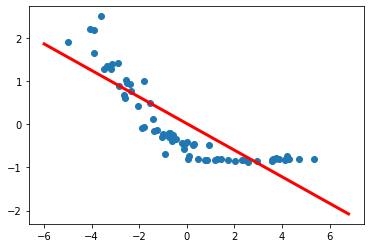

MSE model:  0.17124219884830044
R2 model:  0.7992311323495751
MSE pca:  0.25266869216625
R2 pca:  0.7037645652876099


In [95]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_moda[:,1:], np_standar_moda[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

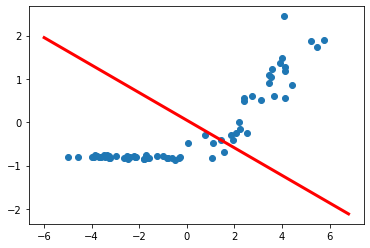

MSE model:  0.14235756043644734
R2 model:  0.8219444820897475
MSE pca:  3.259136214673543
R2 pca:  -3.076405811286886


In [96]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_zero[:,1:], np_standar_zero[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

Según la ejecución la dispersión de los puntos se invierte y el modelo tiene diferente error, esto se debe a que tenemos una base de datos pequeña, después de la eliminación de outliers y el tratamiento de los valores NaN estamos manejando unas 300 filas de información solamente. Esto también causa que cuando comparemos R2, si la distribución del output de test es muy mala de valores bastnte anormales.

Con esta información lo único que nos queda claro es que no hay ninguna política que se diferencie de la otra y que tenemos la necesidad de encontrar un valor de entranamiento que se ajuste lo máximo posible a nuestra base de datos. A partir de ahora trabajaremos solo con el dataset de la política de drop.

Hemos investigado y hemos visto que hay varios criterios para eliminar los atributos. Hemos decidido escoger la opción en la que escogemos un threshold y eliminamos los atributos que tengan una correlación menos a eso. Para llevar a cabo esto hemos cogido el dataframe de correlaciones que creamos en el apartado C.

In [97]:
def RemoveAtrributes(dataset, correlation, min_correlation):
    atributos_buenos = list(map(lambda x: True if abs(float(x))>min_correlation else False, correlation.loc['Recreation Visits']))
    dataset = dataset.loc[:,np.array(atributos_buenos)]
    return dataset

In [98]:
dataset_atributos_eliminados = RemoveAtrributes(dataset_drop, correlacio_drop, 0.3)
dataset_atributos_eliminados.head()

,Recreation Visits,LowestTemperature(F),HighestTemperature(F),WarmestMinimumTemperature(F),ColdestMaximumTemperature(F),AverageMinimumTemperature(F),AverageMaximumTemperature(F),MeanTemperature(F),TotalSnowfall(In),Max 24hrSnowfall(In)
0,30621,-17.0,37.0,23.0,10.0,8.9,29.3,19.1,16.1,6.5
2,26778,-19.0,41.0,26.0,5.0,3.8,27.1,15.5,14.1,2.5
3,24699,-22.0,43.0,30.0,6.0,1.2,23.5,12.3,11.5,3.8
4,24766,-14.0,41.0,28.0,14.0,6.6,29.4,18.0,15.0,3.0
5,24517,2.0,41.0,27.0,12.0,17.8,30.5,24.1,5.1,1.4


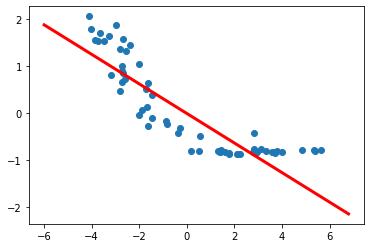

MSE model:  0.12320710616690538
R2 model:  0.8683035567526627
MSE pca:  0.22716129650943137
R2 pca:  0.7571866126518787


In [99]:
standar_dataset = []
for i in range(dataset_atributos_eliminados.shape[1]):
    standar_dataset.append(standarize(dataset_atributos_eliminados.values[:,i]))
np_standar_final = np.transpose(np.array(standar_dataset))
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_final[:, 1:], np_standar_final[:,0])
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)


Aqui hemos visto un primer ejemplo del resutado de la regresion despues de eliminar todos los atributos con una correlación menor a 0.3 y con el entrenamiento por defecto que hemos puesto, que es del 80% para el entrenamiento. No vemos mucha diferencia con el resto de modelos.

Ahora nuestro objetivo es encontrar el mejor umbral para la correlación y el mejor porcentage de train, así que lo que hacemos es probar el model 50 con cada combinación y hacer la media

In [100]:
select_mse = []
select_r2 = []
threshold = 0
while(threshold <= 0.7):
    train = 0.5
    while (round(train,2) <= 0.8):
        dataset_proof = RemoveAtrributes(dataset_drop, correlacio_drop, 0.3)
        proof_standard = []
        for i in range(dataset_proof.shape[1]):
            proof_standard.append(standarize(dataset_proof.values[:,i]))
        np_proof_standard = np.transpose(np.array(proof_standard))
        cont = 0
        cont_r2 = 0
        for i in range(50):
            regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_proof_standard[:, 1:], np_proof_standard[:,0], train_percent=train, plot=False)
            cont += regr_err
            cont_r2 += regr_r2
        select_mse.append([threshold, train, cont/50])
        select_r2.append([threshold, train, cont_r2/50])
        train += 0.05
    threshold += 0.1
media_threshold = [0]*8
media_train = [0]*7
media_threshold_r2 = [0]*8
media_train_r2 = [0]*7
for (i,item) in enumerate(select_mse):
    if(round(item[0],1)==0):
        media_threshold[0] += item[2]
        media_threshold_r2[0] += select_r2[i][2]
    if(round(item[0],1)==0.1):
        media_threshold[1] += item[2]
        media_threshold_r2[1] += select_r2[i][2]
    if(round(item[0],1)==0.2):
        media_threshold[2] += item[2]
        media_threshold_r2[2] += select_r2[i][2]
    if(round(item[0],1)==0.3):
        media_threshold[3] += item[2]
        media_threshold_r2[3] += select_r2[i][2]
    if(round(item[0],1)==0.4):
        media_threshold[4] += item[2]
        media_threshold_r2[4] += select_r2[i][2]
    if(round(item[0],1)==0.5):
        media_threshold[5] += item[2]
        media_threshold_r2[5] += select_r2[i][2]
    if(round(item[0],1)==0.6):
        media_threshold[6] += item[2]
        media_threshold_r2[6] += select_r2[i][2]
    if(round(item[0],1)==0.7):
        media_threshold[7] += item[2]
        media_threshold_r2[7] += select_r2[i][2]
    if(round(item[1],2)==0.50):
        media_train[0] += item[2]
        media_train_r2[0] += select_r2[i][2]
    if(round(item[1],2)==0.55):
        media_train[1] += item[2]
        media_train_r2[1] += select_r2[i][2]
    if(round(item[1],2)==0.60):
        media_train[2] += item[2]
        media_train_r2[2] += select_r2[i][2]
    if(round(item[1],2)==0.65):
        media_train[3] += item[2]
        media_train_r2[3] += select_r2[i][2]
    if(round(item[1],2)==0.70):
        media_train[4] += item[2]
        media_train_r2[4] += select_r2[i][2]
    if(round(item[1],2)==0.75):
        media_train[5] += item[2]
        media_train_r2[5] += select_r2[i][2]
    if(round(item[1],2)==0.80):
        media_train[6] += item[2]
        media_train_r2[6] += select_r2[i][2]
print('Errores train:')
print(list(map(lambda x: x/8, media_train)))
print('------------------------')
print('Errores threshold:')
print(list(map(lambda x: x/6, media_threshold)))
print('------------------------')
print('R2 train:')
print(list(map(lambda x: x/8, media_train_r2)))
print('------------------------')
print('R2 threshold:')
print(list(map(lambda x: x/6, media_threshold_r2)))


Errores train:
[0.16050841478759503, 0.16022400280032317, 0.15913394019913993, 0.16057115138654066, 0.15698013817595208, 0.15508952621151167, 0.15837696300642232]
------------------------
Errores threshold:
[0.1855625813951626, 0.18525381806642008, 0.1838199643057119, 0.18488515705117528, 0.18559363057409292, 0.1877324488976755, 0.18559083107822993, 0.18274041738817817]
------------------------
R2 train:
[0.8371831854373892, 0.838664685315645, 0.8396658535070018, 0.8379725277089741, 0.8403793034726506, 0.841627068419428, 0.839038797576956]
------------------------
R2 threshold:
[0.9783471897249916, 0.9793262146205003, 0.9793572603294584, 0.9805945078749478, 0.9789910519117281, 0.9774711120193472, 0.9789034952512957, 0.9797177301851238]


Vemos que no encontramos muchas diferencias entre los diferentes valores, esto creemos que se basa en tres factores, el primero es que hay pocos datos como ya hemos mencionado anteriormente y por eso cuesta encontrar buenos porcentages de training, el segundo factor es que nuestro modelo es de grado uno y por lo que es dificil que se ajuste bien a los datos y finalmente que los pesos se ajustan de tal manera que aquellos atributos que eliminamos ya se les asigna un peso prácticamente de 0 porque lo que es lo mismo que eliminarlos. Por lo tanto, continuaremos tratando todos los datos y con porcentage de train del 80%.

En el siguiente código lo que hacemos es printar los pesos que ha asignado nuestra regresión para ver a que atributos les da una mayor importancia.

In [101]:
dataset_final = RemoveAtrributes(dataset_drop, correlacio_drop, 0)
final_list = []
for i in range(dataset_final.shape[1]):
    final_list.append(standarize(dataset_final.values[:,i]))
np_final = np.transpose(np.array(final_list))
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_final[:, 1:], np_final[:,0], plot=False)
print('Estos son los coeficiente de la regresión: ')
nombre_atributos = list(dataset_drop)
for i, item in enumerate(regr.coef_):
    print(nombre_atributos[i], ': ', item)

Estos son los coeficiente de la regresión: 
Recreation Visits :  0.0
LowestTemperature(F) :  0.15464598376254027
HighestTemperature(F) :  -0.6082892987227613
WarmestMinimumTemperature(F) :  0.3974876987154251
ColdestMaximumTemperature(F) :  -0.1113575538651517
AverageMinimumTemperature(F) :  2.6025089450003605
AverageMaximumTemperature(F) :  6.078019934378019
MeanTemperature(F) :  -7.5111840184899386
TotalPrecipitation(In) :  0.03849143902605227
TotalSnowfall(In) :  0.20082672274453986
Max 24hrPrecipitation(In) :  0.016871416642604244
Max 24hrSnowfall(In) :  -0.18315235136589236
3month Percent Change Airfare Costs :  0.012790094460206122
3month Percent Change Food Away From Home Costs :  -0.002638449869883294
3month Percent Change Gasoline Costs :  0.012269627640925596
3month Percent Change Jet Fuel Costs :  0.03705331790908316
Consumer Price Index :  -0.07114957276359672
Consumer Sentiment Index :  -0.03452530870079339
Unemployment Rate :  0.0037964343042969396
Year :  0.0488517274737

Como comentabamos antes, estabamos en lo cierto, asigna persos cercanos al cero a aquellos atributos que que diponen de poco sentido para la regresión.

## Extra: Modelo grado 2
Hemos profundizado en el tema y hemos buscado una forma de que el modelo tenga más grados, una vez hemos encontrado la solución hemos hecho las mismas comprobación que antes para ver cuál es el mejor porcentaje de train y de correlaciones para este modelo

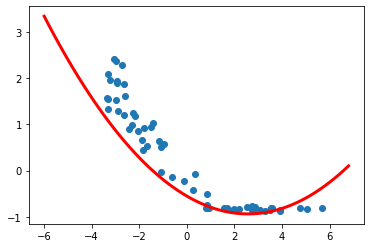

MSE model:  4.1925688294255385
R2 model:  -2.426638342161778
MSE pca:  0.3792436935464476
R2 pca:  0.6900394402094123


In [111]:
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_standar_drop[:,1:], np_standar_drop[:,0], degree=2)
print('MSE model: ', regr_err)
print('R2 model: ', regr_r2)
print('MSE pca: ', pca_err)
print('R2 pca: ', pca_r2)

Visualmente vemos que con un grado 2 se ajusta más aun que también observamos que el error es bastante alto, otra cosa a tener en cuenta es que según la ejecución los datos en la gráfica también se puede ver de una forma diferente, esto es porque seguimos entrenando con el 80% de los datos y son bastante pocos.

Ahora lo que vamos a hacer es buscar con que combinación de atributos y porcentage de entramiento se adapta mejor, igual que hemos hecho antes.

In [103]:
select_mse = []
select_r2 = []
threshold = 0
while(threshold <= 0.7):
    train = 0.5
    while (round(train,2) <= 0.8):
        dataset_proof = RemoveAtrributes(dataset_drop, correlacio_drop, 0.3)
        proof_standard = []
        for i in range(dataset_proof.shape[1]):
            proof_standard.append(standarize(dataset_proof.values[:,i]))
        np_proof_standard = np.transpose(np.array(proof_standard))
        cont = 0
        cont_r2 = 0
        for i in range(50):
            regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_proof_standard[:, 1:], np_proof_standard[:,0], train_percent=train, plot=False, degree=2)
            cont += regr_err
            cont_r2 += regr_r2
        select_mse.append([threshold, train, cont/50])
        select_r2.append([threshold, train, cont_r2/50])
        train += 0.05
    threshold += 0.1
media_threshold = [0]*8
media_train = [0]*7
media_threshold_r2 = [0]*8
media_train_r2 = [0]*7
for (i,item) in enumerate(select_mse):
    if(round(item[0],1)==0):
        media_threshold[0] += item[2]
        media_threshold_r2[0] += select_r2[i][2]
    if(round(item[0],1)==0.1):
        media_threshold[1] += item[2]
        media_threshold_r2[1] += select_r2[i][2]
    if(round(item[0],1)==0.2):
        media_threshold[2] += item[2]
        media_threshold_r2[2] += select_r2[i][2]
    if(round(item[0],1)==0.3):
        media_threshold[3] += item[2]
        media_threshold_r2[3] += select_r2[i][2]
    if(round(item[0],1)==0.4):
        media_threshold[4] += item[2]
        media_threshold_r2[4] += select_r2[i][2]
    if(round(item[0],1)==0.5):
        media_threshold[5] += item[2]
        media_threshold_r2[5] += select_r2[i][2]
    if(round(item[0],1)==0.6):
        media_threshold[6] += item[2]
        media_threshold_r2[6] += select_r2[i][2]
    if(round(item[0],1)==0.7):
        media_threshold[7] += item[2]
        media_threshold_r2[7] += select_r2[i][2]
    if(round(item[1],2)==0.50):
        media_train[0] += item[2]
        media_train_r2[0] += select_r2[i][2]
    if(round(item[1],2)==0.55):
        media_train[1] += item[2]
        media_train_r2[1] += select_r2[i][2]
    if(round(item[1],2)==0.60):
        media_train[2] += item[2]
        media_train_r2[2] += select_r2[i][2]
    if(round(item[1],2)==0.65):
        media_train[3] += item[2]
        media_train_r2[3] += select_r2[i][2]
    if(round(item[1],2)==0.70):
        media_train[4] += item[2]
        media_train_r2[4] += select_r2[i][2]
    if(round(item[1],2)==0.75):
        media_train[5] += item[2]
        media_train_r2[5] += select_r2[i][2]
    if(round(item[1],2)==0.80):
        media_train[6] += item[2]
        media_train_r2[6] += select_r2[i][2]
print('Errores train:')
print(list(map(lambda x: x/8, media_train)))
print('------------------------')
print('Errores threshold:')
print(list(map(lambda x: x/6, media_threshold)))
print('------------------------')
print('R2 train:')
print(list(map(lambda x: x/8, media_train_r2)))
print('------------------------')
print('R2 threshold:')
print(list(map(lambda x: x/6, media_threshold_r2)))

Errores train:
[0.5656156337364926, 0.4825898858780632, 0.3246266174602216, 0.25996156369072837, 0.26625647196607044, 0.289328544416535, 0.14822044013981042]
------------------------
Errores threshold:
[0.42742036865360217, 0.43946902650289515, 0.3467352879317093, 0.38249069706485755, 0.3848155701810118, 0.3449881088786831, 0.39075248055959505, 0.3987940032782081]
------------------------
R2 train:
[0.43079596872122006, 0.5158626513188759, 0.6736296656842613, 0.7371418478614913, 0.7315860885586792, 0.7007043575233063, 0.8444943070632014]
------------------------
R2 threshold:
[0.7354055104793238, 0.7229129684829049, 0.813712997884703, 0.7765244773587902, 0.7816745803127741, 0.8188160241714506, 0.7705559712178611, 0.7593506524002397]


Vemos que ahora los valores de correlacion y entrenamiento si que afectan significativamente, vemos que el mejor porcentage de entrenamiento es de 0.80 y que la correlación óptima se encuentra utilizando los atributos que tiene una correlación igual o superior a 0.3, hay que tener en cuenta que en nuestros datos poner un umbral de 0.3, 0.4, 0.5 o 0.6 no cambia en nada puesto que no hay correlaciones que esten entre esos valores.

Ahora, al igual que hemos hecho para el modelo de un solo grado vamos a mirar que pesos le asigna la regresión a cada atributo con la selección de train y threshold que hemos encontrado antes que era óptima.

In [104]:
dataset_final_2 = RemoveAtrributes(dataset_drop, correlacio_drop, 0.3)
final_list_2 = []
for i in range(dataset_final_2.shape[1]):
    final_list_2.append(standarize(dataset_final_2.values[:,i]))
np_final_2 = np.transpose(np.array(final_list_2))
regr, regr_err, pca_regr, pca_err, regr_r2, pca_r2 = valorate_dataset(np_final_2[:, 1:], np_final_2[:,0], plot=False)
print('Estos son los coeficiente de la regresión: ')
nombre_atributos = list(dataset_final_2)
for i, item in enumerate(regr.coef_):
    print(nombre_atributos[i], ': ', item)

Estos son los coeficiente de la regresión: 
Recreation Visits :  0.0
LowestTemperature(F) :  0.24506084622685845
HighestTemperature(F) :  -0.6603311663264857
WarmestMinimumTemperature(F) :  0.4334933372814125
ColdestMaximumTemperature(F) :  -0.22849233861482707
AverageMinimumTemperature(F) :  7.304258314694987
AverageMaximumTemperature(F) :  12.288631256307449
MeanTemperature(F) :  -18.198635041960763
TotalSnowfall(In) :  0.21352997751469288
Max 24hrSnowfall(In) :  -0.1760004387493752


## Preguntas
**1. Quin són els atributs més importants per fer una bona predicció?**

Según el modelo lineal de un grado no hemos visto que la elimación de atributos se vea afectada pero esto se debe a que aquellos atributos que no le interesan les asigna pesos muy cercanos a zero, entonces viendo los pesos vemos que los atributos más importantes són estos:
- MeanTemperature(F) :  -12.353324380486214
- AverageMaximumTemperature(F) :  8.96482776633843
- AverageMinimumTemperature(F) :  4.626223626264338
También hay otros atributos que parecen ser relevantes pero aún así no son superiores a peso 1.


En el modelo de segundo grado que hemos encontrado también es bastante confuso, pero podríamos decir que los más importante son:

- LowestTemperature(F)
- HighestTemperature(F)
- WarmestMinimumTemperature(F)
- ColdestMaximumTemperature(F)
- AverageMinimumTemperature(F)
- AverageMaximumTemperature(F)
- MeanTemperature(F)
- TotalSnowfall(In)
- Max 24hrSnowfall(In)

Esto basandonos en las medias de error que hemos hecho antes en las cuales iterabamos muchas veces con diferentes valores de train y threshold para ver cuales eran los óptimos. Pero para verlo mejor cogeremos el mejor threshold y el mejor porcentage de train y miraremos dentro de los atributos mencionados anteriormente cuales tienen mayor peso y por lo tanto son los más importantes.
- MeanTemperature(F) :  -14.741664338406927
- AverageMaximumTemperature(F) :  10.246069618413303
- AverageMinimumTemperature(F) :  5.830529241673122
Vemos que los atributos con mayor peso siguen siendo los mismo que para el modelo de grado 1 aun que hay un poco su peso.

**2. Amb quin atribut s'assoleix un MSE menor?**

El atributo *MeanTemperature(F)* con un error de 0.19, aproximadamente, es el atributo con menos error que tenemos. Esto es bastante lógico ya también es un atributo que posee buena correlación.

**3. Quina correlació hi ha entre els atributs de la vostra base de dades?**

Abajo he mostrado el resultado de la ejecución donde vemos la correlación de r2. Como podemos observar no nos aporta mucho más conocimiento del que ya disponiamos a estas alturas, y esque los factores ambientales a excepción de las precipitaciones tiene una mayor correlación y el resto no son atributos que se relacionen demasiado. 

Código:

drop estandard: 
[['LowestTemperature(F)', (0.343371655315098, 0.6643355679409595)], ['HighestTemperature(F)', (0.286561476846208, 0.7306055401135492)], ['WarmestMinimumTemperature(F)', (0.2415378869872381, 0.7324826658540275)], ['ColdestMaximumTemperature(F)', (0.2725281188912056, 0.7474588671770912)], ['AverageMinimumTemperature(F)', (0.2840687472910272, 0.6716131199504407)], ['AverageMaximumTemperature(F)', (0.1710243470983515, 0.8445266779726643)], ['MeanTemperature(F)', (0.1939596449107449, 0.7930234069122502)], ['TotalPrecipitation(In)', (0.9156745546193178, 0.04124286070479399)], ['TotalSnowfall(In)', (0.7030325687138941, 0.4127123579606601)], ['Max 24hrPrecipitation(In)', (0.8742550901457415, -0.06349620410046519)], ['Max 24hrSnowfall(In)', (0.561006572174073, 0.33623299614123536)], ['3month Percent Change Airfare Costs', (0.9699699598898199, -0.006525761653899398)], ['3month Percent Change Food Away From Home Costs', (1.0703065171092494, -0.015135186087568808)], ['3month Percent Change Gasoline Costs', (0.8836139821914254, 0.031922626108033536)], ['3month Percent Change Jet Fuel Costs', (0.9942459043609517, -0.04795289280817827)], ['Consumer Price Index', (1.0662974995093495, -0.03762809990797278)], ['Consumer Sentiment Index', (1.0414132072599014, -0.014167055054739475)], ['Unemployment Rate', (0.9177380463702838, -0.039780020043556075)], ['Year', (0.8787947937061884, -0.010725724644041312)], ['Month', (0.8783789379183881, -0.001652764007398666)]]


**4. Com influeix la normalització en la regressió?**

La normalización baja mucho el error, sin normalizar el error podia ser de 1^10, mientras que despues de normalizar los valores por lo general tiene valores entre 0.1 y 1.3 aproximadamente.

**5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?**

En nuestro caso no ha mejorado, pero es porque tenemos muy pocos datos y también porque si miramos la distribución de nuestro valor objetivo su distribución es bastante mala, ya que la mayoria de valores se encuentran similares y esto dificulta la predicción. Otro factor también relevante es el hecho de que la regresión ya ajustaba los pesos en función de la importancia y aquellos atributos que eliminabamos les ponia un peso muy próximo a cero.

**6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?**

En nuestro caso lo reducimos a 1, ya que queremos printarlo en una gráfica 2D, pero se puede reducir a la cantidad que se desee, si hubiesemos querido printar en 3D el modelo hubiesemos reducido a 2 el espacio.

# Apartado A: Regresión(II)

El objetivo que habia aquí era repetir el apartado B pero haciendo manualmente el descensio de gradiente.

Esta apartado no esta terminado, ya que por problemas de tiempo nos ha sido imposible terminarlo. Hemos creado la clase de Regresion pero tiene algunos errores y un método para regularizar los erroresde diferentes formas, con *L1*, *L2* y *Elastic Net*. Hemos dejado el trabajo que hemos realizado aunque no funcione.

In [105]:
def computed_error(w, aplha, regular_type, y1, y2, r):
    if (regular_type == 'L1'):
        aux = 0
        for item in w:
            aux += abs(item)
        c=(1/len(w)) + aux 
    elif (regular_type == 'L2'):
        aux = 0
        for item in w:
            aux += item**2
        c=(1/(len(w)*2)) + aux 
    elif (regular_typer == 'ElasticNet'):
        aux = 0
        for item in w:
            aux += abs(item)
        c1=(1/len(w)) + aux 
        aux = 0
        for item in w:
            aux += item**2
        c2=(1/(len(w)*2)) + aux
        c = r*c1+(1-r)*c2
    return mean_squeared_error(y1, y2)+aplha*c

In [106]:
def gradientDescent(x, y, theta, aplha, m, numIterations, regular_type, aplha_error, r, epsilon):
    xTrans = x.tanspose()
    error_ant = None
    for i in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypotesis - y
        cost = computed_error(theta, aplha_error, regular_type, hypotesis, y, r)
        print("Iteration %d | Cost: %f" % (i, cost))
        gradient = np.dot(xTrans, loss) / m
        theta = theta - aplha * gradient
        if(error_ant != None and cost-error_ant < epsilon):
            print("Sale del descenso de gradiente: Margen de mejora mínimo")
            return theta
        error_ant = cost
    print("Sale del descenso de gradiente: Maximo de iteraciones")
    return theta

In [107]:
class Regressor(object):
    def __init__(self, w0, w1, w2, w3, w4, w5, w6,w7, w8, w9, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.w6 = w6
        self.w7 = w7
        self.w8 = w8
        self.w9 = w9
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        theta = np.array([self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.w7, self.w8, self.w9])
        predict = np.dot(theta, x)
        predict += self.w0
        return predict
    
    def __update(self, hy, y, regular_type, alpha_error, r, xTrans):
        theta = [self.w0, self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.w7, self.w8, self.w9]
        loss = hy - y
        cost = computed_error(theta, alpha_error, regular_type, hy, y, r)
        print("Iteration %d | Cost: %f" % (i, cost))
        gradient = np.dot(xTrans, loss) / y.shape[0]
        print(y.shape[0])
        theta = theta - self.alpha * gradient
        self.w0 = theta[0]
        self.w1 = theta[1]
        self.w2 = theta[2]
        self.w3 = theta[3]
        self.w4 = theta[4]
        self.w5 = theta[5]
        self.w6 = theta[6]
        self.w7 = theta[7]
        self.w8 = theta[8]
        self.w9 = theta[9]
        return theta[1:], cost
    
    def train(self, max_iter, epsilon, x, y, regular_type, alpha_error, r=0.5):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        theta = [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.w7, self.w8, self.w9]
        xTrans = x.transpose()
        error_ant = None
        for i in range(0, max_iter):
            hypothesis = np.dot(x, theta)
            hypothesis += self.w0
            theta, cost = self.__update(hypothesis, y, regular_type, alpha_error, r, xTrans)
            if(error_ant != None and cost-error_ant < epsilon):
                print("Sale del descenso de gradiente: Margen de mejora mínimo")
                return theta
            error_ant = cost
        print("Sale del descenso de gradiente: Maximo de iteraciones")
        return theta

In [108]:
#np_standar_drop es el dataset que utilizaremos
proof_standard = []
dataset_proof = RemoveAtrributes(dataset_drop, correlacio_drop, 0.3)
for i in range(dataset_proof.shape[1]):
    proof_standard.append(standarize(dataset_proof.values[:,i]))
np_prof_standard = np.transpose(np.array(proof_standard))
print(np_prof_standard.shape[1])
regr = Regressor(1,1,1,1,1,1,1,1,1,1, 0.5)
regr.train(10, 0.5, np_prof_standard[:, 1:], np_prof_standard[:, 0], 'L1', 0.5, 0.5)

10
Iteration 9 | Cost: 27.447289
300


ValueError: operands could not be broadcast together with shapes (10,) (9,) 

%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)